In [1]:
# https://platform.olimpiada-ai.ro/problems/4

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score
import cv2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
train = pd.read_csv("/kaggle/input/byzantine-notation/dataset_train.csv")
test = pd.read_csv("/kaggle/input/byzantine-notation/dataset_eval.csv")

join_func = lambda x: os.path.join('/kaggle/input/byzantine-notation', x)

train['Path'] = train['Path'].map(join_func)
test['datapointID'] = test['datapointID'].map(join_func)

len(train), len(test)

(416, 328)

In [4]:
class2idx, idx2class = dict(), dict()
class2val = dict()

for i, v in enumerate(train['Effect'].unique()):
    class2idx[v] = i
    idx2class[i] = v
    if v not in ['A', 'B']:
        class2val[v] = int(v)
    else:
        class2val[v] = 0

train['class'] = train['Effect'].map(class2idx.get)

train.head(3)

,Path,Effect,class
0,/kaggle/input/byzantine-notation/training_img/...,A,0
1,/kaggle/input/byzantine-notation/training_img/...,A,0
2,/kaggle/input/byzantine-notation/training_img/...,-1,1


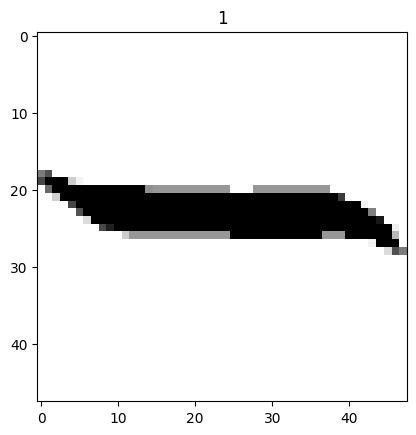

In [5]:
i = 150

plt.title(train['Effect'][i])
plt.imshow(Image.open(train['Path'][i]), cmap='gray')

plt.show()

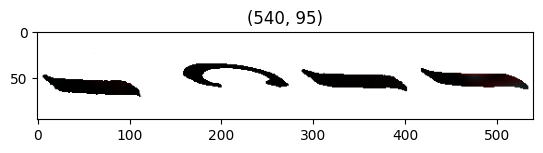

In [6]:
i = 3

plt.title(Image.open(test['datapointID'][i]).size)
plt.imshow(Image.open(test['datapointID'][i]), cmap='gray')

In [7]:
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        super().__init__()
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        img = Image.open(self.df['Path'][idx]).convert("L")
        label = self.df['class'][idx]
        if self.transform is not None:
            img = self.transform(img)
            img = 1 - img
        return img, label

train, valid = train_test_split(train, test_size=0.2, random_state=42, stratify=train['class'])
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((48, 48))
])

train_ds = CustomDataset(train, transform)
valid_ds = CustomDataset(valid, transform)

BATCH_SIZE = 32

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True)

In [31]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=8):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=7, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # nn.MaxPool2d(2),
            
            nn.Conv2d(16, 64, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.MaxPool2d(2),

            nn.Conv2d(128, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*12*12, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.classifier(self.conv(x))

epochs = 10
log_rate = 1

torch.manual_seed(42)
torch.cuda.manual_seed(42)
model = SimpleCNN().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_losses, valid_losses, accs = [], [], []

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0
    i = 0
    for X, y in (pbar := tqdm(train_loader, leave=False)):
        i += 1
        X, y = X.to(device), y.to(device)
        output = model(X)
        loss = loss_fn(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pbar.set_postfix({'loss': f'{train_loss/i:.5f}'})

    train_losses.append(train_loss/i)
    
    if (epoch+1)%log_rate==0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/i:.5f}")
    
    model.eval()
    valid_loss = 0
    all_targets, all_preds = [], []
    i = 0
    for X, y in (pbar := tqdm(valid_loader, leave=False)):
        i += 1
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            output = model(X)
            loss = loss_fn(output, y)

        probs = torch.softmax(output, dim=-1)
        preds = torch.argmax(probs, dim=-1)
        
        valid_loss += loss.item()
        all_targets.extend(y.squeeze().tolist())
        all_preds.extend(preds.squeeze().tolist())
        pbar.set_postfix({'loss': f'{valid_loss/i:.5f}'})

    acc = accuracy_score(all_preds, all_targets)

    valid_losses.append(valid_loss/i)
    accs.append(acc)
    
    if (epoch+1)%log_rate==0:
        print(f"Valid Loss: {valid_loss/i:.5f} | Accuracy: {acc:.5f}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 1.05482


  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 2.03379 | Accuracy: 0.38095


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/10 | Train Loss: 0.21325


  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 1.73566 | Accuracy: 0.60714


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.07435


  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 0.95997 | Accuracy: 0.90476


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.04724


  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 0.31510 | Accuracy: 0.95238


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.01715


  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 0.12351 | Accuracy: 0.97619


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 0.01183


  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 0.07685 | Accuracy: 0.98810


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 0.00651


  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 0.05484 | Accuracy: 0.98810


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8/10 | Train Loss: 0.00682


  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 0.04361 | Accuracy: 0.97619


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9/10 | Train Loss: 0.00496


  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 0.03570 | Accuracy: 1.00000


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10/10 | Train Loss: 0.00368


  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 0.02764 | Accuracy: 1.00000


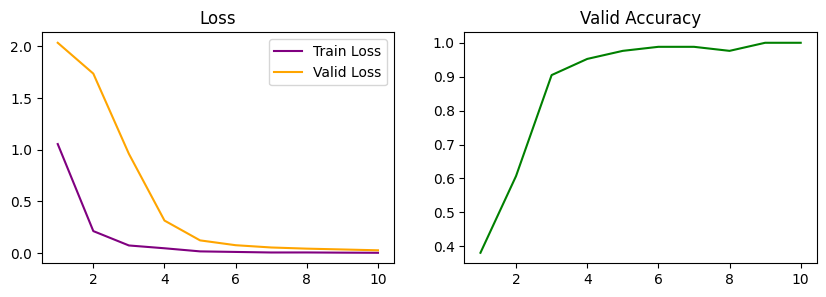

In [33]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, color='purple', label='Train Loss')
plt.plot(range(1, epochs+1), valid_losses, color='orange', label='Valid Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), accs, color='green')
plt.title('Valid Accuracy')

plt.show()

In [34]:
def extract_images(path, visualize=False):
    big_img = np.array(Image.open(path).convert('L'))
    h, w = big_img.shape
    starts, ends = [], []
    for colid in range(w):
        col_bf = big_img[:, colid-1] if colid!=0 else np.ones(h)*255
        col = big_img[:, colid]
        col_af = big_img[:, colid+1] if colid!=w-1 else np.ones(h)*255
        
        col_bf_has = (col_bf==255).sum() != h
        col_has = (col==255).sum() != h
        col_af_has = (col_af==255).sum() != h

        if col_has and not col_bf_has:
            starts.append(colid)
        if col_has and not col_af_has:
            ends.append(colid)
    
    assert len(starts) == len(ends), "Lenghtes don't match -> Starts != Ends"

    images = []
    for s, e in zip(starts, ends):
        images.append(big_img[:, s:e+1])

    if visualize:
        for i in starts:
            big_img[:, i] = np.ones(h)*100
        for i in ends:
            big_img[:, i] = np.ones(h)*100
    
        plt.imshow(big_img, cmap='gray')
        return
    
    return images

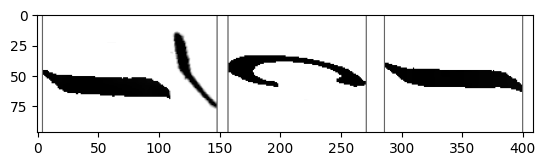

In [35]:
extract_images(test['datapointID'][5], visualize=True)

In [49]:
def extract_images(path, visualize=False):
    img = np.array(Image.open(path).convert('L'))
    
    img = cv2.GaussianBlur(img, (5, 5), 0)
    
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    contours, hierarchy = cv2.findContours(img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

    if visualize:
        img_vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(img_vis, contours, -1, (0,255,0), 1)
        plt.title(len(contours))
        plt.imshow(img_vis)
        return

    starts_ends = []
    
    for con in contours:
        coords_w = con[:, 0, 0]
        starts_ends.append((coords_w.min(), coords_w.max()))

    starts_ends.sort(key=lambda x: x[0])
    
    images = []
    for (s, e) in starts_ends:
        subimg = img[:, s:e+1].copy()
        # subimg = np.pad(subimg, ((0, 15), (0, 0)), mode='constant', constant_values=0)
        images.append(subimg)
    return images

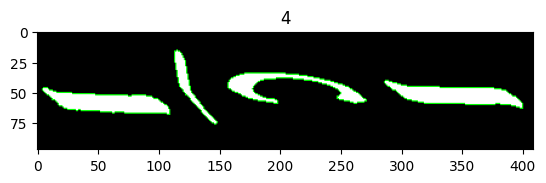

In [50]:
extract_images(test['datapointID'][5], visualize=True)

In [51]:
# plt.imshow(transform(extract_images(test['datapointID'][3], visualize=False)[0]).squeeze().numpy(), cmap='gray')

In [52]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((48, 48))
])

def get_val(image):
    image = transform(image).unsqueeze(1).to(device)
    
    with torch.no_grad():
        output = model(image)
        
    probs = torch.softmax(output, dim=-1)
    preds = torch.argmax(probs, dim=-1)

    return class2val[idx2class[preds.item()]]

def get_answer(path):
    images = extract_images(path)
    vals = [get_val(image) for image in images]
    for i in range(1, len(vals)):
        vals[i] += vals[i-1]
    return '|'.join([str(v) for v in vals])

In [53]:
# plt.imshow(Image.open(test['datapointID'][3]), cmap='gray')

In [54]:
# get_answer(test['datapointID'][3])

In [55]:
# plt.imshow(Image.open(train[train['Effect'] == '1']['Path'].tolist()[2]), cmap='gray')

In [56]:
subm = pd.read_csv("/kaggle/input/byzantine-notation/dataset_eval.csv")

subm['answer'] = test['datapointID'].map(get_answer)

subm

,subtaskID,datapointID,answer
0,1,eval_img/12.png,-2
1,1,eval_img/14.png,1
2,1,eval_img/19.png,4
3,1,eval_img/20.png,0|-2|-2|-2
4,1,eval_img/23.png,0|-2|-2|-2|-2|-1|-1|0|1
...,...,...,...
323,1,eval_img/s11r.png,0|0|0|0|0|0|0|0|0|0|0
324,1,eval_img/s12r.png,0|0|0|0|0|0|0|0|0|0|0|0
325,1,eval_img/s13r.png,1|2|3|4|5|6|7|8|9|10|11|12|13
326,1,eval_img/s14r.png,0|0|0|0|0|0|0|0|0|0|0|0|0|0


In [57]:
subm.to_csv("submission.csv", index=False)